In [199]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [200]:
import numpy as np
import matplotlib.pyplot as plt

import networkx as nx
from networkx.algorithms import smallworld
import random
from collections import Counter
from scipy.spatial import cKDTree

In [201]:
from src.neuron_population import NeuronPopulation
from src.connectome import Connectome
from src.overhead import Simulation
from src.neuron_templates import neuron_type_IZ
from src.network_grower import *
from src.network_generators import *
from src.neuron_type_distributor import *
from src.network_weight_distributor import *
from src.external_inputs import *

In [202]:
weight_scale = 1.0
g = 1.2984752590298583 * 10

J_I = weight_scale * g
J_E = weight_scale
delay_mean_E = 1.5
delay_std_E = delay_mean_E * 0.2
delay_mean_I = 1.5
delay_std_I = delay_mean_I * 0.2
v_ext = 0.45527031369449

excitatory_type = "ss4"
inhibitory_type = "b"

In [203]:
seed = 1234

## Generate network

In [204]:
G = nx.DiGraph()

rng = np.random.default_rng(seed)


n_neurons = int(1000 * 1.0)

I_percent = 0.2

n_excitatory = int(n_neurons * (1 - I_percent))

density = 0.1
    
# Add n_neurons nodes
for i in range(n_neurons):
    G.add_node(i)

# Assign excitatory and inhibitory neurons
# excitatory_nodes = random.sample(range(n_neurons), n_excitatory)

for i in range(n_excitatory):
        G.nodes[i]['inhibitory'] = False
        G.nodes[i]['ntype'] = excitatory_type
        G.nodes[i]['layer'] = 0

for i in range(n_excitatory, n_neurons):
        G.nodes[i]['inhibitory'] = True
        G.nodes[i]['ntype'] = inhibitory_type
        G.nodes[i]['layer'] = 0

# For each node, draw m outgoing edges to random nodes
n_out = int(n_neurons * density)
for i in range(n_neurons):
    targets = rng.choice(range(n_neurons), n_out, replace=False)
    for target in targets:
        if G.nodes[i]['inhibitory']:
            weight = J_I
            delay = max(0.1, rng.normal(delay_mean_I, delay_std_I))
        else:
            weight = J_E
            delay = max(0.1, rng.normal(delay_mean_E, delay_std_E))
        G.add_edge(i, target, weight=weight, distance=delay)

In [205]:
# Redistribute lognormally
G = assign_lognormal_weights_for_ntype(G, "ss4", mu=0.0, sigma=1.643570, w_max=100.0, rng=rng)

Text(0.5, 1.0, 'ss4 Weight Distribution after Lognormal Redistribution')

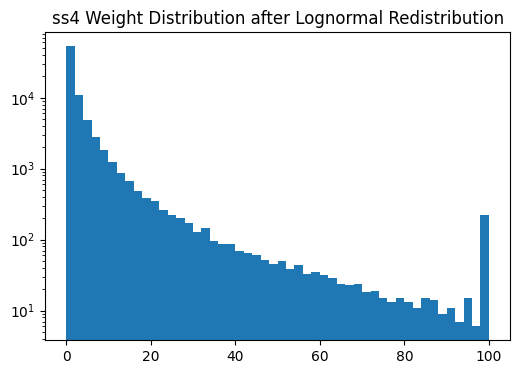

In [206]:
# Plot ss4 weight distribution
weights = [G[u][v]['weight'] for u, v in G.edges() if G.nodes[u]['ntype'] == 'ss4']
plt.figure(figsize=(6,4))
plt.hist(weights, bins=50, log=True)
plt.title("ss4 Weight Distribution after Lognormal Redistribution")

## Simulation setup

In [207]:
dt = 0.1

In [208]:
# Neuron population parameters
n_neurons = G.number_of_nodes()
neuron_types = [excitatory_type, inhibitory_type]
n_neuron_types = len(neuron_types)
inhibitory = [False, True]
threshold_decay = np.exp(-dt / 5)

pop = NeuronPopulation(n_neurons, neuron_types, inhibitory, threshold_decay)

In [209]:
# Connectome
# Max number of outgoing synapses per neuron
max_synapses = max(dict(G.out_degree()).values())

connectome = Connectome(max_synapses, pop)

connectome.nx_to_connectome(G)

In [210]:
nmda_weight = np.ones(connectome.neuron_population.n_neurons, dtype=float)
nmda_weight[pop.inhibitory_mask.astype(bool)] = 0.959685703507305 * 0.5
# Invert to make excitatory neurons have NMDA weight 1, inhibitory 0
# nmda_weight

## Simulation

100%|██████████| 15000/15000 [00:14<00:00, 1067.65it/s]


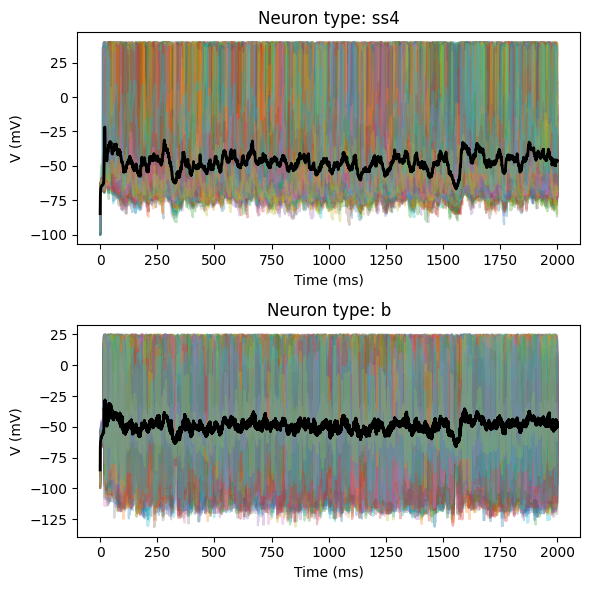

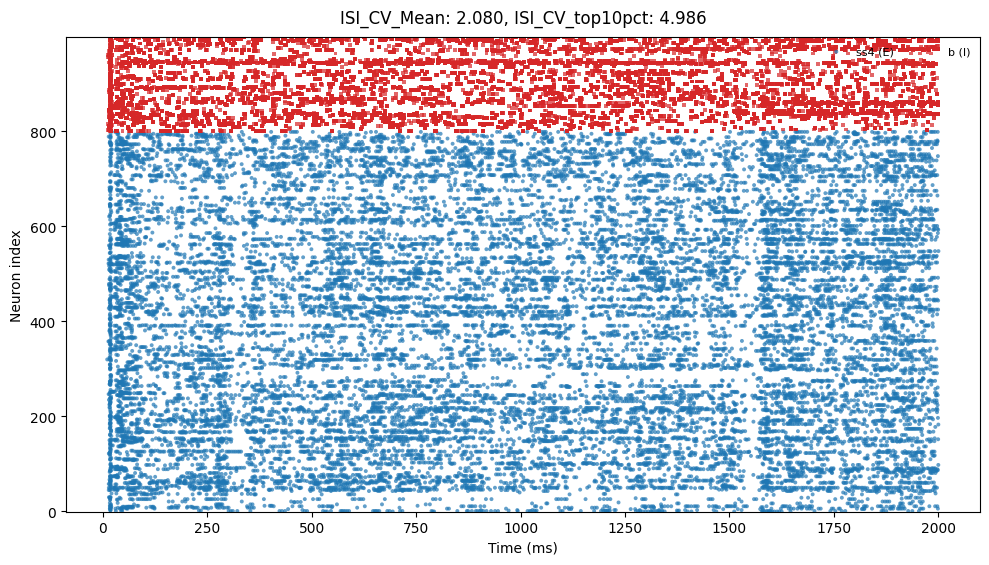

In [211]:

# Randomize initial voltages
Vs = rng.uniform(-100, -70, size=n_neurons)
us = rng.uniform(0, 400, size=n_neurons)
spikes = np.zeros(n_neurons, dtype=bool)
Ts = np.zeros_like(spikes)

state0 = (Vs,
          us,
          spikes.copy(),
          Ts.copy())

# sim = Simulation(connectome, dt, stepper_type="simple", state0=state0,
#                  enable_plasticity=False)
sim = Simulation(connectome, dt, stepper_type="euler_det", state0=state0,
                 enable_plasticity=False, synapse_kwargs={"LT_scale": 1.0, "NMDA_weight": nmda_weight}, synapse_type="standard",
                 enable_debug_logger=True)

# rate = np.zeros(n_neurons)
poisson = PoissonInput(n_neurons, rate=v_ext, amplitude=2.44625509556019)

from tqdm import tqdm

for i in tqdm(range(5000)):
    sensory_spikes = poisson(dt)
    sensory_spikes[pop.inhibitory_mask.astype(bool)] = False
    sim.step(spike_ext=sensory_spikes)
    # sim.step()

for i in tqdm(range(15000)):
    sim.step()

sim.plot_voltage_per_type(figsize=(6, 6))

stats = sim.stats.compute_metrics(dt, bin_ms_participation=300)

isi_mean = stats['ISI_CV_mean']
isi_top = stats["ISI_CV_mean_top10pct"]

sim.plot_spike_raster(figsize=(10, 6), title=f"ISI_CV_Mean: {isi_mean:.3f}, ISI_CV_top10pct: {isi_top:.3f}", t_start_ms=0.0, t_stop_ms=9000.0)

In [212]:
sim.stats.compute_metrics(dt, bin_ms_participation=300, t_start_ms=250.0, t_stop_ms=2000.0)

{'rate_mean_Hz': 23.76628571428572,
 'rate_median_Hz': 6.285714285714286,
 'rate_p95_Hz': 84.59999999999997,
 'rate_mean_Hz_E': 12.440714285714286,
 'rate_mean_Hz_I': 69.06857142857143,
 'rate_mean_Hz_E_active2spk': 18.00985221674877,
 'rate_mean_Hz_I_active2spk': 85.77462289263532,
 'ISI_CV_median': 1.6353826920490901,
 'ISI_CV_mean': 1.9704732543558274,
 'ISI_CV_mean_E': 1.568257832514755,
 'ISI_CV_mean_I': 3.3094613683557847,
 'ISI_CV_mean_top10pct': 4.863073080559179,
 'refractory_violations_per_neuron': 20.042,
 'Fano_median_2ms': 0.9908466819221865,
 'Fano_median_10ms': 1.3218390804597624,
 'Fano_median_50ms': 2.0000000000000004,
 'Fano_median_100ms': 2.375,
 'Fano_median_300ms': 3.0,
 'Fano_median_500ms': 2.774134790528233,
 'Fano_median_1000ms': 0.0,
 'mean_noise_corr_2ms': 0.0014585609167710734,
 'mean_noise_corr_10ms': 0.004281531740127391,
 'mean_noise_corr_50ms': 0.004957640955700627,
 'mean_noise_corr_100ms': 0.00455555024426801,
 'mean_noise_corr_300ms': 0.004887652678914

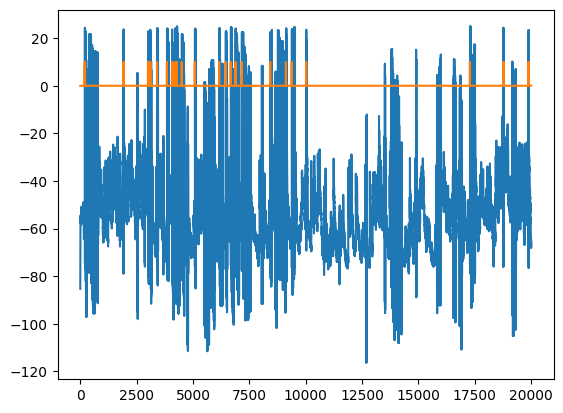

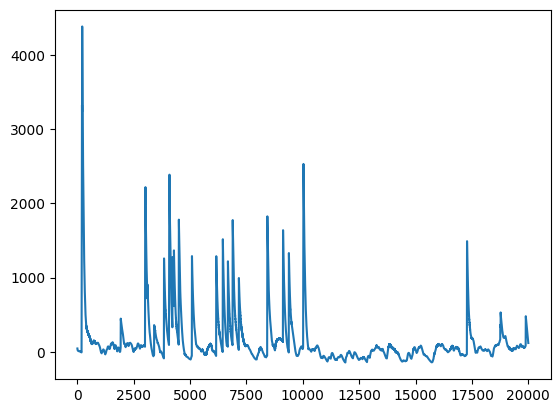

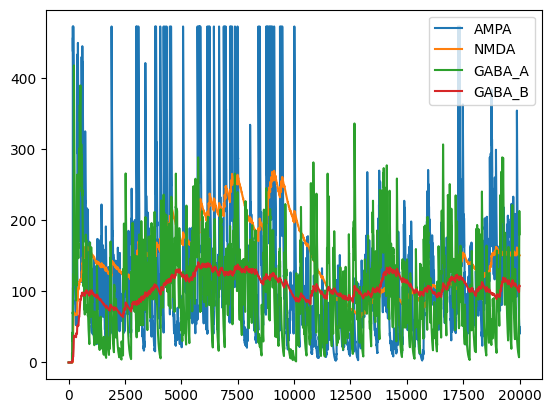

In [228]:
# Plot spikes for one neuron
n_idx = 828
t_first = 0
t_last = -1
plt.plot(np.array(sim.stats.Vs)[t_first:t_last,n_idx])
plt.plot(np.array(sim.stats.spikes)[t_first:t_last,n_idx] * 10)
plt.show()
plt.plot(np.array(sim.stats.us)[t_first:t_last,n_idx])
plt.show()
plt.plot(np.array(sim.debug_logger.s_ampa)[t_first:t_last,n_idx], label="AMPA")
plt.plot(np.array(sim.debug_logger.s_nmda)[t_first:t_last,n_idx], label="NMDA")
plt.plot(np.array(sim.debug_logger.s_gaba_a)[t_first:t_last,n_idx], label="GABA_A")
plt.plot(np.array(sim.debug_logger.s_gaba_b)[t_first:t_last,n_idx], label="GABA_B")
plt.legend()
plt.show()

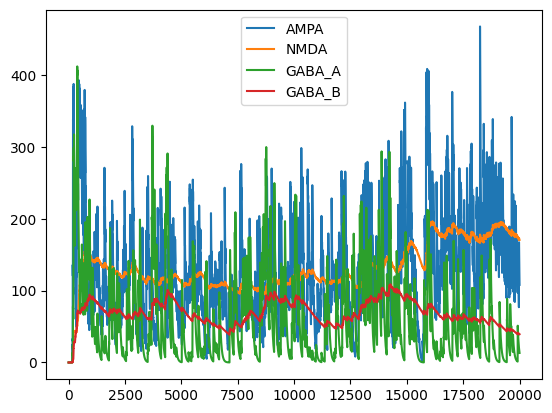

In [214]:
plt.plot(np.array(sim.debug_logger.s_ampa)[t_first:t_last,n_idx], label="AMPA")
plt.plot(np.array(sim.debug_logger.s_nmda)[t_first:t_last,n_idx], label="NMDA")
plt.plot(np.array(sim.debug_logger.s_gaba_a)[t_first:t_last,n_idx], label="GABA_A")
plt.plot(np.array(sim.debug_logger.s_gaba_b)[t_first:t_last,n_idx], label="GABA_B")
plt.legend()
plt.show()

In [215]:
# connectome.compute_metrics(small_world=False)